In [11]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except ModuleNotFoundError:
    print("Installing seaborn")
    !pip install seaborn
    import seaborn as sns

input_dir = os.path.join(os.path.dirname((os.path.abspath(""))), 'data') 
df = pd.read_csv(os.path.join(input_dir, 'training_data.csv'))


### Checking basic statistics for all columns
#### Numeric: Summary statistics, histograms
#### String: Unique values, % occurences

               step        amount  oldbalanceOrig  newbalanceOrig  \
count  5.090096e+06  5.090096e+06    5.090096e+06    5.090096e+06   
mean   2.433927e+02  1.797576e+05    8.333894e+05    8.545642e+05   
std    1.423214e+02  6.016180e+05    2.886947e+06    2.922632e+06   
min    1.000000e+00  0.000000e+00    0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.339572e+04    0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.486501e+04    1.418100e+04    0.000000e+00   
75%    3.350000e+02  2.086447e+05    1.073060e+05    1.441782e+05   
max    7.430000e+02  9.244552e+07    5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud    orig_delta  \
count    5.090096e+06    5.090096e+06  5.090096e+06  5.090096e+06   
mean     1.099593e+06    1.223768e+06  1.295260e-03 -2.117484e+04   
std      3.391912e+06    3.666375e+06  3.596641e-02  1.477697e+05   
min      0.000000e+00    0.000000e+00  0.000000e+00 -1.915268e+06   
25%      0.000000e+00    0.000000

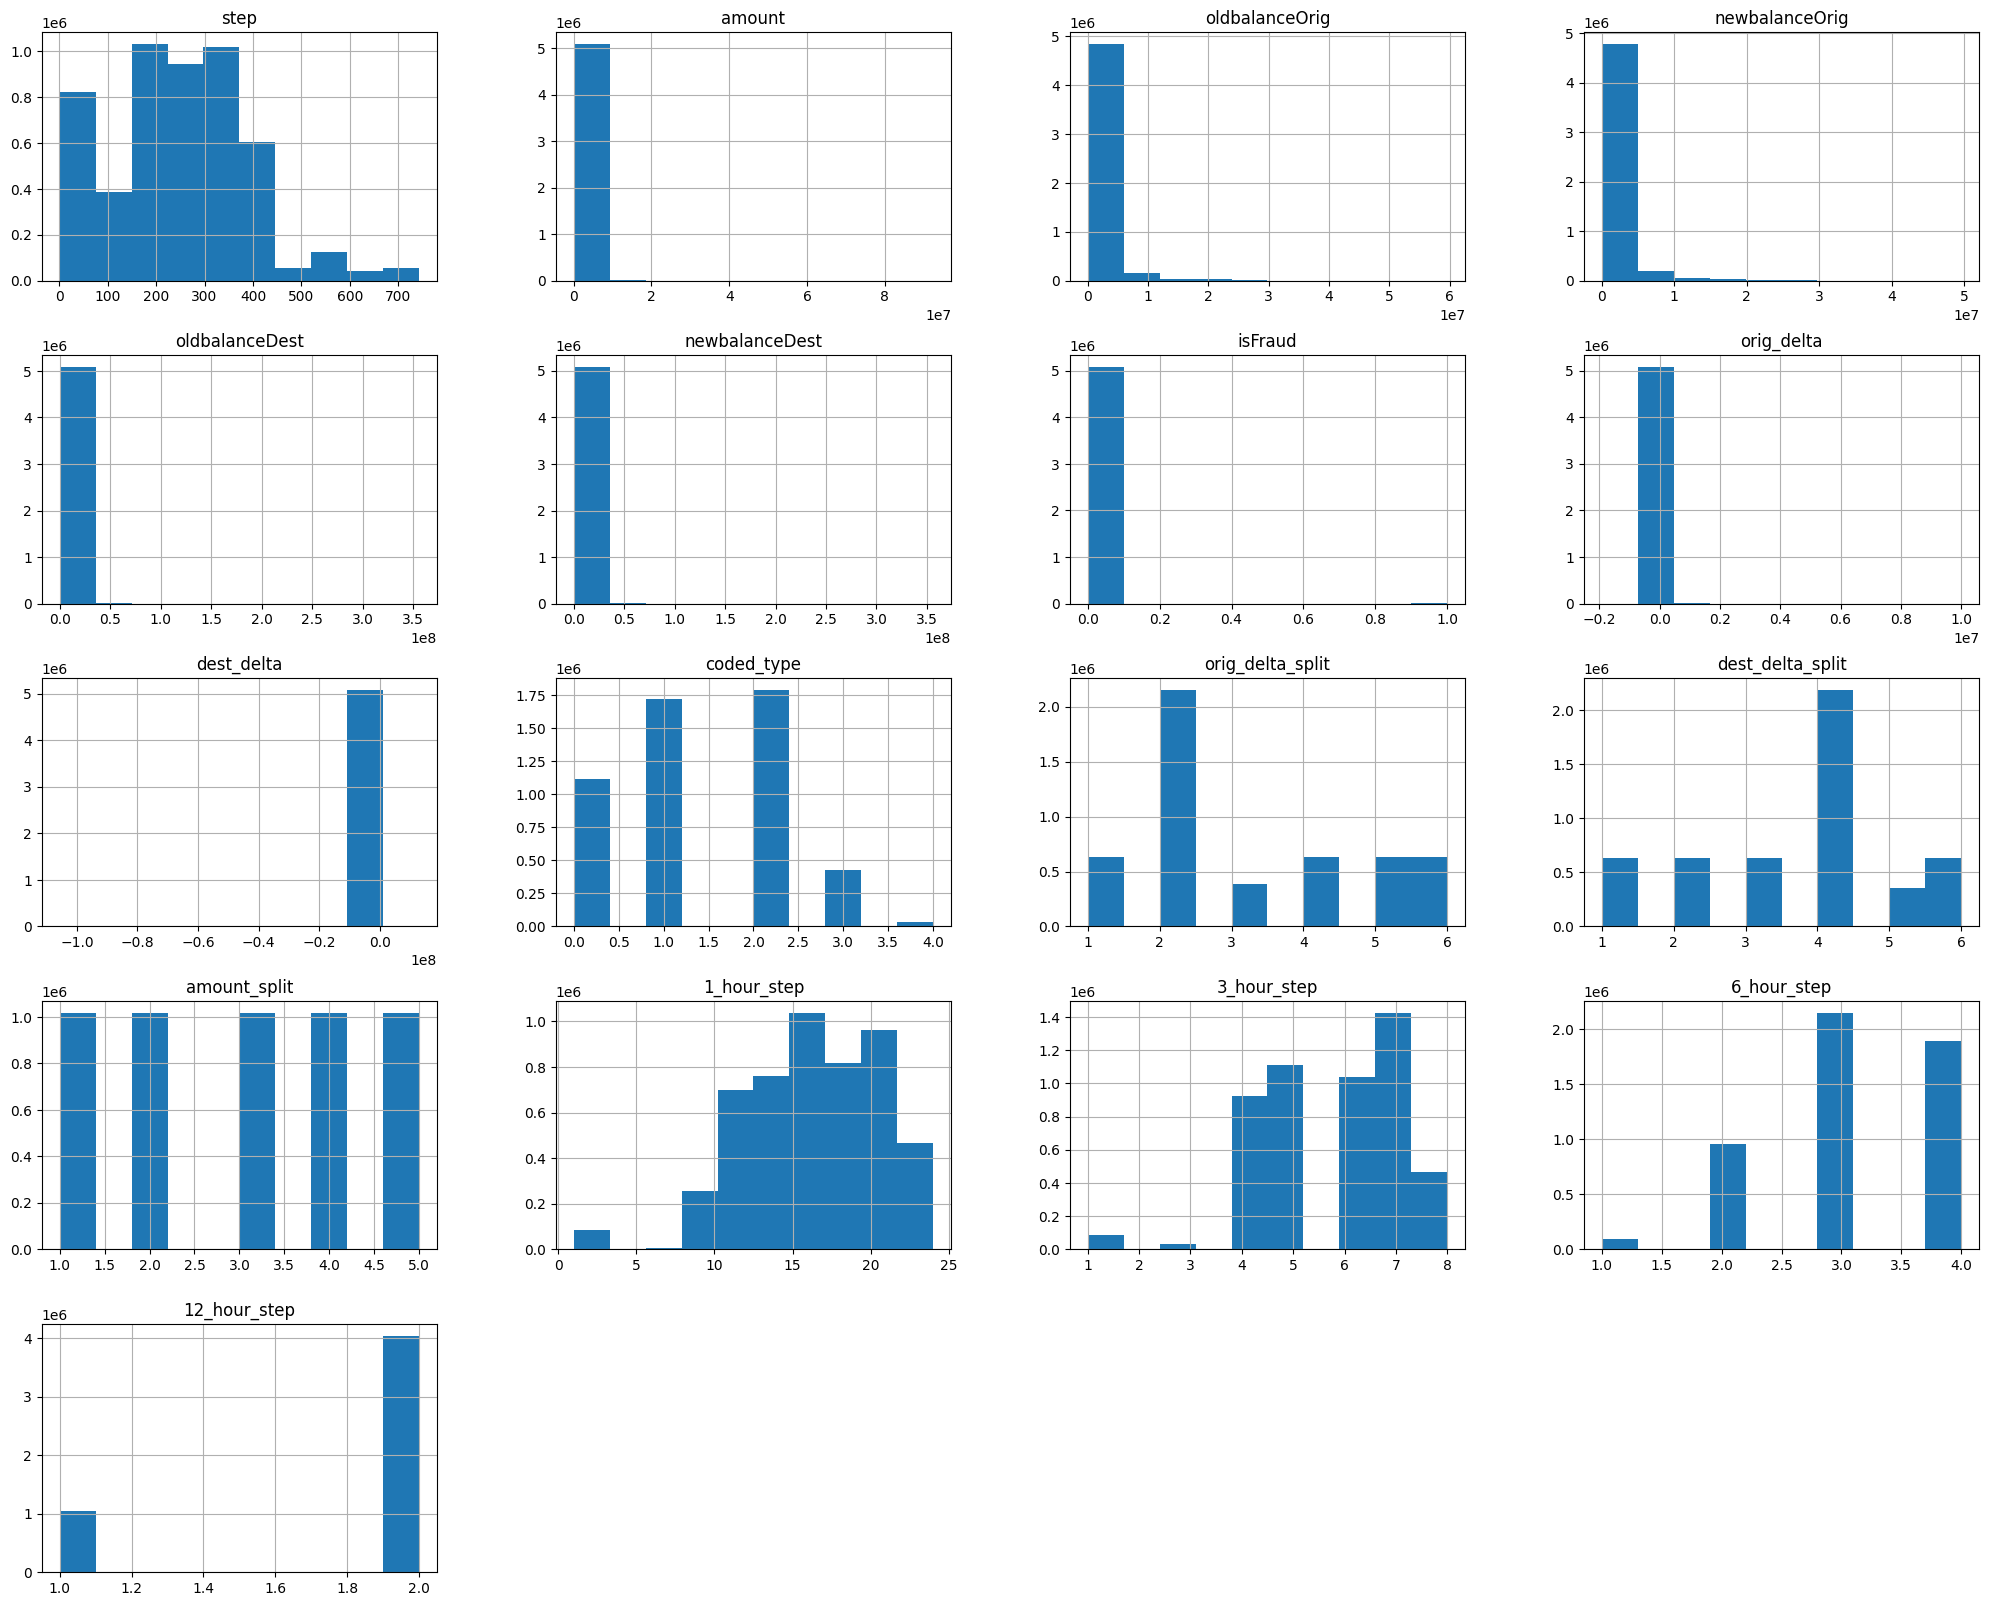

In [17]:
object_columns = df.select_dtypes(['object']).columns
num_columns = df.select_dtypes(['float64', 'int64']).columns
num_columns = num_columns.drop('isFraud')

## Numeric data
# Using in-built statistical summary
print(df.describe())

# Investigating target/class labels:
print(f"% of {len(df)} transactions that are fradulent: {np.mean(df.isFraud)*100:.3g}")
# It is clear that the fraudulent transactions are highly rare - we can assume here that a decision tree, given the probable low entropy of the 'isFraud' target,
# will be best predicted by a decision tree classifer due to its sparse nature.

# Plot histograms for numeric data
df.hist(bins=10, figsize=(25, 20))


## Categorical Data
object_df = pd.DataFrame(columns=['Variable', 'Unique Values', 'Top 5 Categories', 'Top 5 %'])
for column in object_columns:
    nunique = df[column].nunique()
    top_5 = df[column].value_counts().nlargest(5)
    top_5_pct = df[column].value_counts(normalize=True).nlargest(5) * 100
    print(f"Details of {column}:")
    print(f"Unique Values: {nunique}")
    print(f"Top 5 Attribute Values by %:")
    print(top_5_pct)
    print("\n")
    # object_df = object_df._append({'Variable':column, 'Unique Values': nunique, 'Top 5 Category Counts':top_5, 'Top 5 %':top_5_pct}, ignore_index=True)

# From histograms, it is clear that key numeric variables like account balance and amount will need to be investigated further
# In the first experimentation, I'm attempting to split the numeric data into 2-4 buckets based on the
# sample distribution, so that each bucket has roughly the same number of amounts.




### Analysing Correlations between Variables


isFraud             1.000000
fully_depleted      0.988621
orig_delta          0.366168
transaction_10mn    0.134263
amount_is_delta     0.086162
amount              0.078474
orig_delta_split    0.061436
coded_type          0.045714
amount_split        0.032039
step                0.031533
oldbalanceOrig      0.010529
newbalanceDest      0.000746
oldbalanceDest     -0.005782
newbalanceOrig     -0.008113
dest_delta_split   -0.016360
12_hour_step       -0.025846
dest_delta         -0.027565
6_hour_step        -0.029336
1_hour_step        -0.031259
3_hour_step        -0.031726
Name: isFraud, dtype: float64


<Axes: title={'center': 'Correlation Heatmap Between Dataset Columns'}>

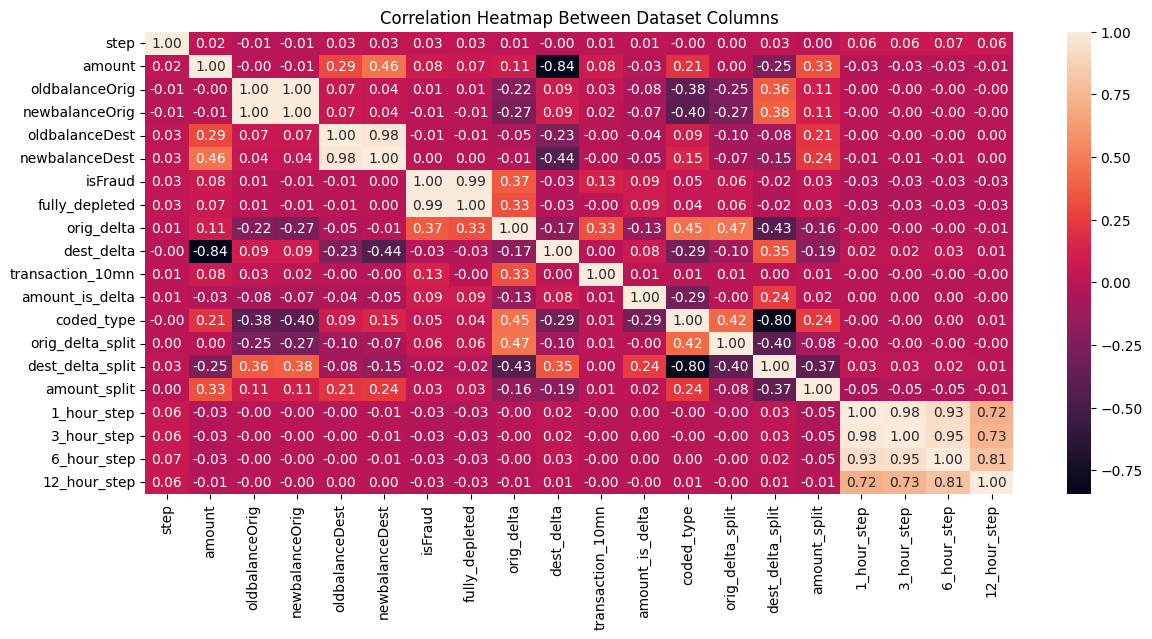

In [14]:
## For numeric variables
correlation = df.drop(columns=['nameOrig_duplicate','nameDest_duplicate']).corr(numeric_only=True)
fraud_correlation = correlation['isFraud'].sort_values(ascending=False)
print(fraud_correlation)

## Using seaborn to visualize correlation matrix

plt.figure(figsize=(14,6))
plt.title("Correlation Heatmap Between Dataset Columns")
sns.heatmap(correlation, annot=True, fmt='.2f')

# A few interesting observations come out here:
# There's a very high correlation between the amount being fully depleted and the transaction being fraudulent
# There's high correlation between new and old balance for the origin and destination accounts, respectively.
    # This is expected, considering if old balance is high, then it's likely the new balance is also high.
# The 3-hour step seems to possess the same amount of correlation with isFraud as the 'step' variable, in the opposite direction
# There is a surprisingly high correlation between origin account balance delta and the isFraud variable.


#### Exploring representation of target classes in each attribute

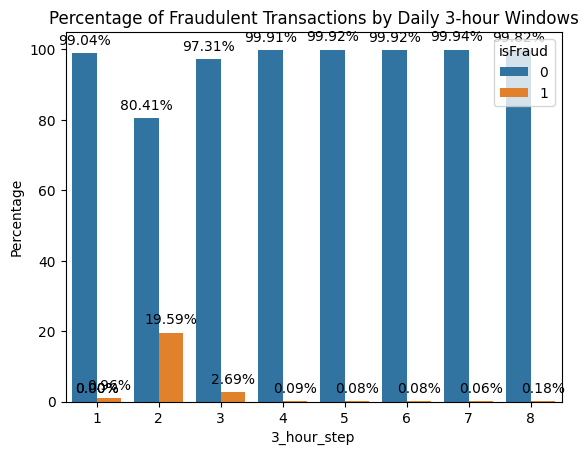

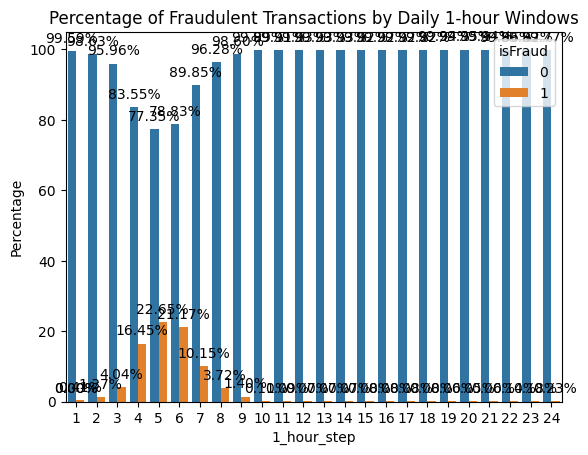

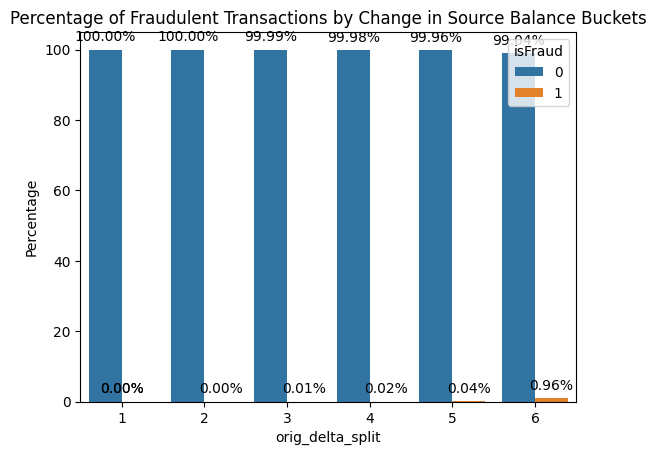

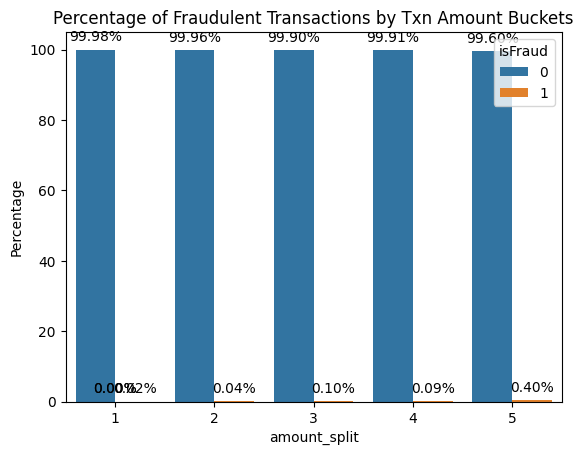

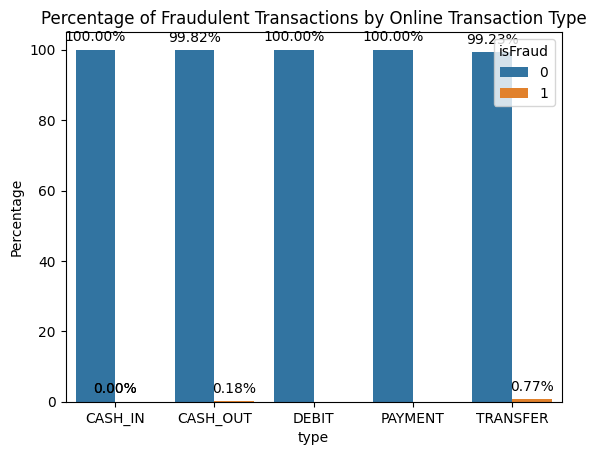

In [23]:
# Given the that this is a classification task, it becomes important to explore how each class
# is represented in the categorical variables. As I've converted the step into a categorical, and noticed
# a small yet interesting correlation between isFraud and the 3_hour_step, I wanted to explore the distributiion
# of isFraud across 3_hour_step to see what was driving the correlation.

# This is done below, by using percentages, since the absolute counts of isFraud occurrences are extremely low in absolute terms.

count_df = df.groupby(['3_hour_step', 'isFraud']).size().reset_index(name='Count')
total_counts = df.groupby(['3_hour_step']).size().reset_index(name='Total')

percentage_df = pd.merge(count_df, total_counts, on='3_hour_step')
percentage_df['Percentage'] = (percentage_df['Count'] / percentage_df['Total']) * 100
barplot = sns.barplot(x='3_hour_step', y='Percentage', hue='isFraud', data=percentage_df)
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f') + '%',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9), textcoords = 'offset points')

plt.title('Percentage of Fraudulent Transactions by Daily 3-hour Windows')
plt.show()

# Repeat with '1 hour' step
count_df = df.groupby(['1_hour_step', 'isFraud']).size().reset_index(name='Count')
total_counts = df.groupby(['1_hour_step']).size().reset_index(name='Total')

percentage_df = pd.merge(count_df, total_counts, on='1_hour_step')
percentage_df['Percentage'] = (percentage_df['Count'] / percentage_df['Total']) * 100
barplot = sns.barplot(x='1_hour_step', y='Percentage', hue='isFraud', data=percentage_df)
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f') + '%',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9), textcoords = 'offset points')

plt.title('Percentage of Fraudulent Transactions by Daily 1-hour Windows')
plt.show()

# Repeat with 'orig_delta_split'
count_df = df.groupby(['orig_delta_split', 'isFraud']).size().reset_index(name='Count')
total_counts = df.groupby(['orig_delta_split']).size().reset_index(name='Total')

percentage_df = pd.merge(count_df, total_counts, on='orig_delta_split')
percentage_df['Percentage'] = (percentage_df['Count'] / percentage_df['Total']) * 100
barplot = sns.barplot(x='orig_delta_split', y='Percentage', hue='isFraud', data=percentage_df)
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f') + '%',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9), textcoords = 'offset points')

plt.title('Percentage of Fraudulent Transactions by Change in Source Balance Buckets')
plt.show()

# Repeat with 'amount_split'
count_df = df.groupby(['amount_split', 'isFraud']).size().reset_index(name='Count')
total_counts = df.groupby(['amount_split']).size().reset_index(name='Total')

percentage_df = pd.merge(count_df, total_counts, on='amount_split')
percentage_df['Percentage'] = (percentage_df['Count'] / percentage_df['Total']) * 100
barplot = sns.barplot(x='amount_split', y='Percentage', hue='isFraud', data=percentage_df)
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f') + '%',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9), textcoords = 'offset points')

plt.title('Percentage of Fraudulent Transactions by Txn Amount Buckets')
plt.show()


# Repeat visualization with 'type' attribute
count_df = df.groupby(['type', 'isFraud']).size().reset_index(name='Count')
total_counts = df.groupby(['type']).size().reset_index(name='Total')

percentage_df = pd.merge(count_df, total_counts, on='type')
percentage_df['Percentage'] = (percentage_df['Count'] / percentage_df['Total']) * 100
barplot = sns.barplot(x='type', y='Percentage', hue='isFraud', data=percentage_df)
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f') + '%',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9), textcoords = 'offset points')
plt.title('Percentage of Fraudulent Transactions by Online Transaction Type')
plt.show()



#### Investigating Behavior of Continuous Numeric Variables and Fraudulent Transactions

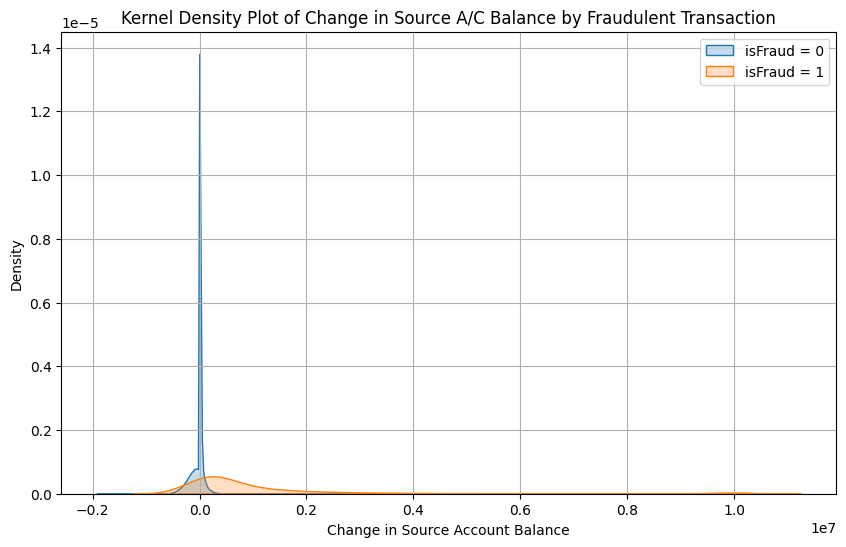

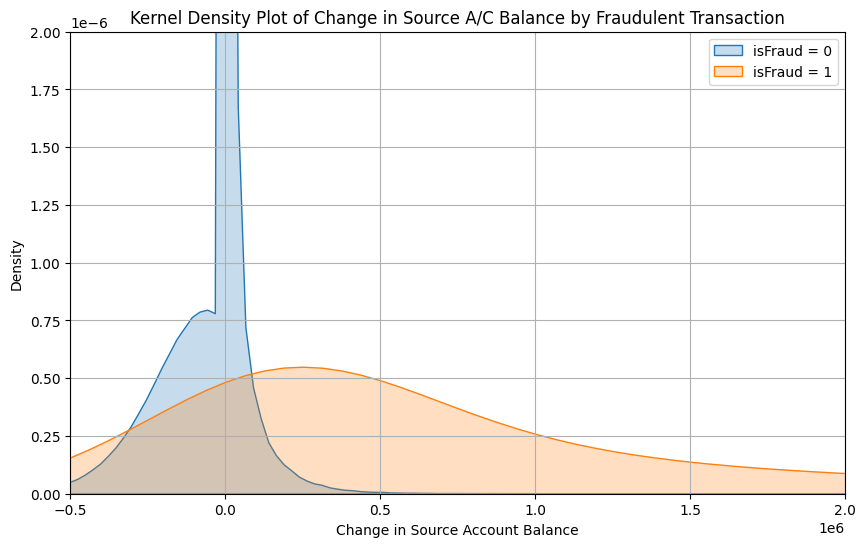

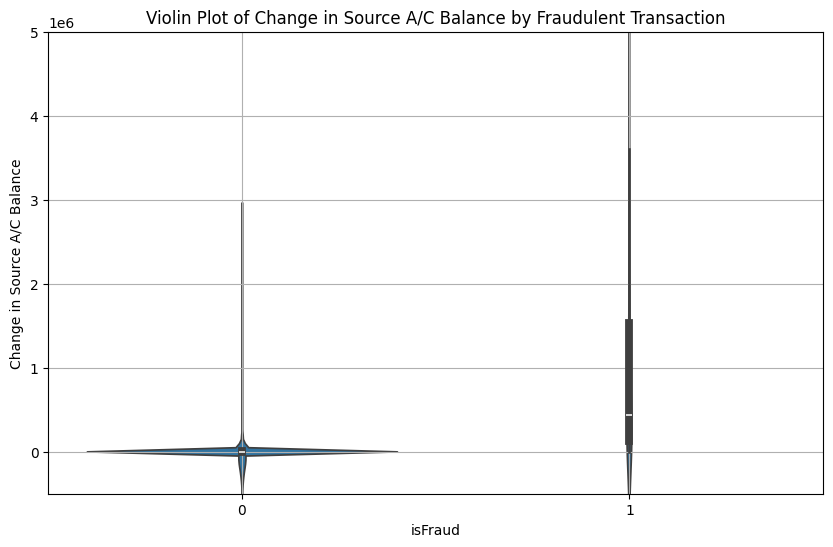

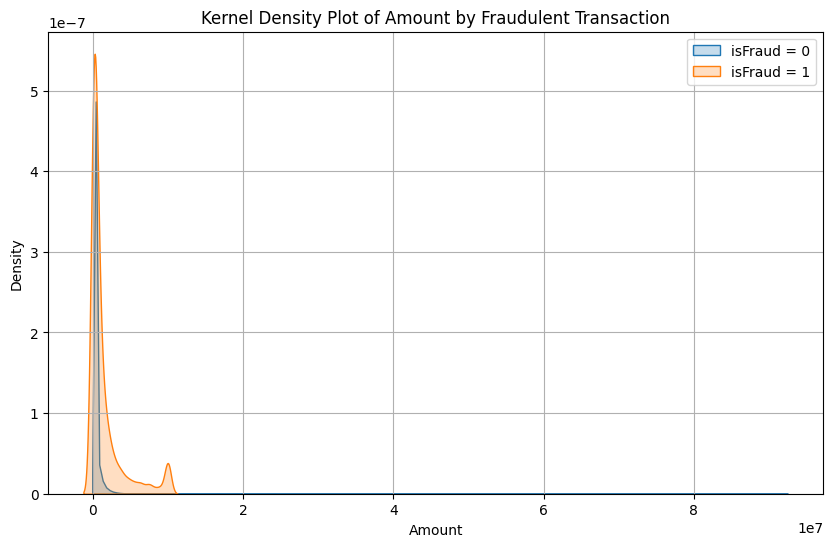

In [25]:

# Plotting KDE of 'orig_delta' and 'isFraud'
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['isFraud'] == 0]['orig_delta'], label='isFraud = 0', fill=True)
sns.kdeplot(df[df['isFraud'] == 1]['orig_delta'], label='isFraud = 1', fill=True)

plt.xlabel('Change in Source Account Balance')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Change in Source A/C Balance by Fraudulent Transaction')
plt.legend()
plt.grid(True)
plt.show()

### Limiting X-axis and Y-axis range:

# Plotting KDE of 'orig_delta' and 'isFraud'
plt.figure(figsize=(10, 6))
# sns.kdeplot(df[df['isFraud'] == 0]['orig_delta'], label='isFraud = 0', fill=True)
sns.kdeplot(df[df['isFraud'] == 1]['orig_delta'], label='isFraud = 1', fill=True)

plt.xlabel('Change in Source Account Balance')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Change in Source A/C Balance by Fraudulent Transaction')
plt.legend()
plt.xlim(-0.05 * 10**7, 0.2 * 10**7)
plt.ylim((0.0 * 10**-5), (0.2 * 10**-5)) 
plt.grid(True)
plt.show()


# Violin Plot (Optional for more detailed distribution insight)
plt.figure(figsize=(10, 6))
sns.violinplot(x='isFraud', y='orig_delta', data=df)
plt.xlabel('isFraud')
plt.ylabel('Change in Source A/C Balance')
plt.ylim((-0.05 * 10**7), (0.5 * 10**7)) 
plt.title('Violin Plot of Change in Source A/C Balance by Fraudulent Transaction')
plt.grid(True)
plt.show()

# Plotting KDE of 'amount' and 'isFraud'
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['isFraud'] == 0]['amount'], label='isFraud = 0', fill=True)
sns.kdeplot(df[df['isFraud'] == 1]['amount'], label='isFraud = 1', fill=True)

plt.xlabel('Amount')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Amount by Fraudulent Transaction')
plt.legend()
plt.grid(True)
plt.show()

_, buckets = pd.qcut(df['orig_delta'], 8, labels=[i for i in range(1,7)], retbins=False, precision=3, duplicates='drop')
print(buckets)
